In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Prepare for Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


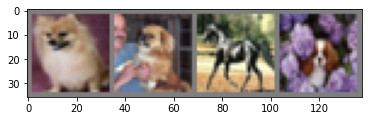

  dog   dog horse   dog


In [3]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = dataiter.next()
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cpu


#### Network Definition

In [5]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
#         self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
#         self.fc1 = nn.Linear(1280, 100)
#         self.fc2 = nn.Linear(100, 10)
        
#     def forward(self, x):
#         x = F.max_pool2d(F.relu(self.conv1(x)), 2)
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#### Optimizer and Loss Function

In [6]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

#### Training Procedure

In [7]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.308
[epoch: 0, i:   199] avg mini-batch loss: 2.300
[epoch: 0, i:   299] avg mini-batch loss: 2.305
[epoch: 0, i:   399] avg mini-batch loss: 2.302
[epoch: 0, i:   499] avg mini-batch loss: 2.300
[epoch: 0, i:   599] avg mini-batch loss: 2.298
[epoch: 0, i:   699] avg mini-batch loss: 2.295
[epoch: 0, i:   799] avg mini-batch loss: 2.287
[epoch: 0, i:   899] avg mini-batch loss: 2.287
[epoch: 0, i:   999] avg mini-batch loss: 2.281
[epoch: 0, i:  1099] avg mini-batch loss: 2.262
[epoch: 0, i:  1199] avg mini-batch loss: 2.236
[epoch: 0, i:  1299] avg mini-batch loss: 2.177
[epoch: 0, i:  1399] avg mini-batch loss: 2.155
[epoch: 0, i:  1499] avg mini-batch loss: 2.100
[epoch: 0, i:  1599] avg mini-batch loss: 2.083
[epoch: 0, i:  1699] avg mini-batch loss: 2.073
[epoch: 0, i:  1799] avg mini-batch loss: 2.054
[epoch: 0, i:  1899] avg mini-batch loss: 2.017
[epoch: 0, i:  1999] avg mini-batch loss: 1.977
[epoch: 0, i:  2099] avg mini-batch loss

[epoch: 1, i:  4699] avg mini-batch loss: 1.305
[epoch: 1, i:  4799] avg mini-batch loss: 1.270
[epoch: 1, i:  4899] avg mini-batch loss: 1.243
[epoch: 1, i:  4999] avg mini-batch loss: 1.339
[epoch: 1, i:  5099] avg mini-batch loss: 1.390
[epoch: 1, i:  5199] avg mini-batch loss: 1.295
[epoch: 1, i:  5299] avg mini-batch loss: 1.281
[epoch: 1, i:  5399] avg mini-batch loss: 1.322
[epoch: 1, i:  5499] avg mini-batch loss: 1.333
[epoch: 1, i:  5599] avg mini-batch loss: 1.318
[epoch: 1, i:  5699] avg mini-batch loss: 1.347
[epoch: 1, i:  5799] avg mini-batch loss: 1.263
[epoch: 1, i:  5899] avg mini-batch loss: 1.355
[epoch: 1, i:  5999] avg mini-batch loss: 1.356
[epoch: 1, i:  6099] avg mini-batch loss: 1.339
[epoch: 1, i:  6199] avg mini-batch loss: 1.320
[epoch: 1, i:  6299] avg mini-batch loss: 1.384
[epoch: 1, i:  6399] avg mini-batch loss: 1.331
[epoch: 1, i:  6499] avg mini-batch loss: 1.363
[epoch: 1, i:  6599] avg mini-batch loss: 1.231
[epoch: 1, i:  6699] avg mini-batch loss

[epoch: 2, i:  9299] avg mini-batch loss: 1.146
[epoch: 2, i:  9399] avg mini-batch loss: 1.117
[epoch: 2, i:  9499] avg mini-batch loss: 1.149
[epoch: 2, i:  9599] avg mini-batch loss: 1.181
[epoch: 2, i:  9699] avg mini-batch loss: 1.186
[epoch: 2, i:  9799] avg mini-batch loss: 1.165
[epoch: 2, i:  9899] avg mini-batch loss: 1.095
[epoch: 2, i:  9999] avg mini-batch loss: 1.057
[epoch: 2, i: 10099] avg mini-batch loss: 1.059
[epoch: 2, i: 10199] avg mini-batch loss: 1.109
[epoch: 2, i: 10299] avg mini-batch loss: 1.225
[epoch: 2, i: 10399] avg mini-batch loss: 1.183
[epoch: 2, i: 10499] avg mini-batch loss: 1.142
[epoch: 2, i: 10599] avg mini-batch loss: 1.208
[epoch: 2, i: 10699] avg mini-batch loss: 1.121
[epoch: 2, i: 10799] avg mini-batch loss: 1.173
[epoch: 2, i: 10899] avg mini-batch loss: 1.146
[epoch: 2, i: 10999] avg mini-batch loss: 1.177
[epoch: 2, i: 11099] avg mini-batch loss: 1.044
[epoch: 2, i: 11199] avg mini-batch loss: 1.061
[epoch: 2, i: 11299] avg mini-batch loss

[epoch: 4, i:  1399] avg mini-batch loss: 0.900
[epoch: 4, i:  1499] avg mini-batch loss: 1.004
[epoch: 4, i:  1599] avg mini-batch loss: 0.959
[epoch: 4, i:  1699] avg mini-batch loss: 0.918
[epoch: 4, i:  1799] avg mini-batch loss: 1.022
[epoch: 4, i:  1899] avg mini-batch loss: 1.008
[epoch: 4, i:  1999] avg mini-batch loss: 0.874
[epoch: 4, i:  2099] avg mini-batch loss: 0.924
[epoch: 4, i:  2199] avg mini-batch loss: 1.022
[epoch: 4, i:  2299] avg mini-batch loss: 1.015
[epoch: 4, i:  2399] avg mini-batch loss: 0.990
[epoch: 4, i:  2499] avg mini-batch loss: 0.972
[epoch: 4, i:  2599] avg mini-batch loss: 1.083
[epoch: 4, i:  2699] avg mini-batch loss: 0.921
[epoch: 4, i:  2799] avg mini-batch loss: 1.031
[epoch: 4, i:  2899] avg mini-batch loss: 1.062
[epoch: 4, i:  2999] avg mini-batch loss: 0.924
[epoch: 4, i:  3099] avg mini-batch loss: 0.996
[epoch: 4, i:  3199] avg mini-batch loss: 0.972
[epoch: 4, i:  3299] avg mini-batch loss: 1.000
[epoch: 4, i:  3399] avg mini-batch loss

[epoch: 5, i:  5999] avg mini-batch loss: 0.887
[epoch: 5, i:  6099] avg mini-batch loss: 0.948
[epoch: 5, i:  6199] avg mini-batch loss: 0.831
[epoch: 5, i:  6299] avg mini-batch loss: 0.880
[epoch: 5, i:  6399] avg mini-batch loss: 0.919
[epoch: 5, i:  6499] avg mini-batch loss: 0.914
[epoch: 5, i:  6599] avg mini-batch loss: 1.066
[epoch: 5, i:  6699] avg mini-batch loss: 0.842
[epoch: 5, i:  6799] avg mini-batch loss: 0.857
[epoch: 5, i:  6899] avg mini-batch loss: 0.928
[epoch: 5, i:  6999] avg mini-batch loss: 0.852
[epoch: 5, i:  7099] avg mini-batch loss: 1.023
[epoch: 5, i:  7199] avg mini-batch loss: 0.893
[epoch: 5, i:  7299] avg mini-batch loss: 1.031
[epoch: 5, i:  7399] avg mini-batch loss: 0.894
[epoch: 5, i:  7499] avg mini-batch loss: 0.923
[epoch: 5, i:  7599] avg mini-batch loss: 0.917
[epoch: 5, i:  7699] avg mini-batch loss: 0.953
[epoch: 5, i:  7799] avg mini-batch loss: 0.937
[epoch: 5, i:  7899] avg mini-batch loss: 0.894
[epoch: 5, i:  7999] avg mini-batch loss

[epoch: 6, i: 10599] avg mini-batch loss: 0.847
[epoch: 6, i: 10699] avg mini-batch loss: 0.955
[epoch: 6, i: 10799] avg mini-batch loss: 1.002
[epoch: 6, i: 10899] avg mini-batch loss: 0.889
[epoch: 6, i: 10999] avg mini-batch loss: 0.935
[epoch: 6, i: 11099] avg mini-batch loss: 0.830
[epoch: 6, i: 11199] avg mini-batch loss: 0.799
[epoch: 6, i: 11299] avg mini-batch loss: 0.922
[epoch: 6, i: 11399] avg mini-batch loss: 0.891
[epoch: 6, i: 11499] avg mini-batch loss: 0.998
[epoch: 6, i: 11599] avg mini-batch loss: 0.972
[epoch: 6, i: 11699] avg mini-batch loss: 0.967
[epoch: 6, i: 11799] avg mini-batch loss: 0.879
[epoch: 6, i: 11899] avg mini-batch loss: 0.832
[epoch: 6, i: 11999] avg mini-batch loss: 0.837
[epoch: 6, i: 12099] avg mini-batch loss: 0.874
[epoch: 6, i: 12199] avg mini-batch loss: 0.863
[epoch: 6, i: 12299] avg mini-batch loss: 1.039
[epoch: 6, i: 12399] avg mini-batch loss: 0.906
[epoch: 6, i: 12499] avg mini-batch loss: 0.938
[epoch: 7, i:    99] avg mini-batch loss

[epoch: 8, i:  2699] avg mini-batch loss: 0.773
[epoch: 8, i:  2799] avg mini-batch loss: 0.715
[epoch: 8, i:  2899] avg mini-batch loss: 0.831
[epoch: 8, i:  2999] avg mini-batch loss: 0.773
[epoch: 8, i:  3099] avg mini-batch loss: 0.713
[epoch: 8, i:  3199] avg mini-batch loss: 0.849
[epoch: 8, i:  3299] avg mini-batch loss: 0.777
[epoch: 8, i:  3399] avg mini-batch loss: 0.826
[epoch: 8, i:  3499] avg mini-batch loss: 0.852
[epoch: 8, i:  3599] avg mini-batch loss: 0.902
[epoch: 8, i:  3699] avg mini-batch loss: 0.886
[epoch: 8, i:  3799] avg mini-batch loss: 0.802
[epoch: 8, i:  3899] avg mini-batch loss: 0.851
[epoch: 8, i:  3999] avg mini-batch loss: 0.872
[epoch: 8, i:  4099] avg mini-batch loss: 0.839
[epoch: 8, i:  4199] avg mini-batch loss: 0.741
[epoch: 8, i:  4299] avg mini-batch loss: 0.722
[epoch: 8, i:  4399] avg mini-batch loss: 0.813
[epoch: 8, i:  4499] avg mini-batch loss: 0.765
[epoch: 8, i:  4599] avg mini-batch loss: 0.778
[epoch: 8, i:  4699] avg mini-batch loss

[epoch: 9, i:  7299] avg mini-batch loss: 0.803
[epoch: 9, i:  7399] avg mini-batch loss: 0.720
[epoch: 9, i:  7499] avg mini-batch loss: 0.797
[epoch: 9, i:  7599] avg mini-batch loss: 0.711
[epoch: 9, i:  7699] avg mini-batch loss: 0.872
[epoch: 9, i:  7799] avg mini-batch loss: 0.871
[epoch: 9, i:  7899] avg mini-batch loss: 0.816
[epoch: 9, i:  7999] avg mini-batch loss: 0.844
[epoch: 9, i:  8099] avg mini-batch loss: 0.829
[epoch: 9, i:  8199] avg mini-batch loss: 0.772
[epoch: 9, i:  8299] avg mini-batch loss: 0.740
[epoch: 9, i:  8399] avg mini-batch loss: 0.773
[epoch: 9, i:  8499] avg mini-batch loss: 0.830
[epoch: 9, i:  8599] avg mini-batch loss: 0.821
[epoch: 9, i:  8699] avg mini-batch loss: 0.846
[epoch: 9, i:  8799] avg mini-batch loss: 0.785
[epoch: 9, i:  8899] avg mini-batch loss: 0.851
[epoch: 9, i:  8999] avg mini-batch loss: 0.771
[epoch: 9, i:  9099] avg mini-batch loss: 0.917
[epoch: 9, i:  9199] avg mini-batch loss: 0.777
[epoch: 9, i:  9299] avg mini-batch loss

#### Training Loss Curve

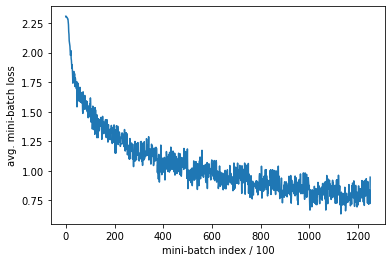

In [8]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

#### Evaluate on Test Dataset

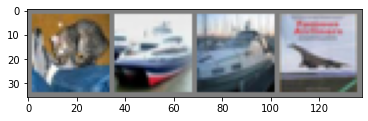

GroundTruth:    cat  ship  ship plane
Predicted:    dog   car  ship plane


In [9]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [10]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [11]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 75 %
Accuracy of  bird : 54 %
Accuracy of   cat : 54 %
Accuracy of  deer : 53 %
Accuracy of   dog : 56 %
Accuracy of  frog : 60 %
Accuracy of horse : 66 %
Accuracy of  ship : 72 %
Accuracy of truck : 74 %
